# **Ninjacart: CV Classification**


* Ninjacart is India's largest fresh produce supply chain company. They are pioneers in solving one of the toughest supply chain problems of the world by leveraging innovative technology. They source fresh produce from farmers and deliver them to businesses within 12 hours. An integral component of their automation process is the development of robust classifiers which can distinguish between images of different types of vegetables, while also correctly labeling images that do not contain any one type of vegetable as noise.

* As a starting point, ninjacart has provided us with a dataset scraped from the web which contains train and test folders, each having 4 sub-folders with images of onions, potatoes, tomatoes and some market scenes. We have been tasked with preparing a multiclass classifier for identifying these vegetables. The dataset provided has all the required images to achieve the task.


**Context**

This dataset contains images of the following food items: noise-Indian market and images of vegetables- onion, potato and tomato.

**Content**

This dataset contains a folder train, which has a total of 3135 images, split into four folders as follows:

* Tomato : 789
*  Potato : 898
*  Onion : 849
*  Indian market : 599

This dataset contains another folder test which has a total of 351 images, split into four folders

* Tomato : 106
* potato : 83
* onion : 81
* Indian market : 81


**Inspiration**

The objective is to develop a program that can recognize the vegetable item(s) in a photo and identify them for the user.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import random
import os
import glob
import tensorflow as tf
from tensorflow import keras # this allows <keras.> instead of <tf.keras.>
from tensorflow.keras import layers # this allows <layers.> instead of <tf.keras.layers.>
tf.keras.utils.set_random_seed(111) # set random seed

# To supress any warnings during the flow
import warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({'font.size': 14})

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)

Mounted at /content/gdrive/


In [5]:
import gdown

In [6]:
!gdown 1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT

Downloading...
From: https://drive.google.com/uc?id=1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT
To: /content/ninjacart_data.zip
100% 275M/275M [00:01<00:00, 222MB/s]


In [7]:
!unzip ninjacart_data.zip

Archive:  ninjacart_data.zip
   creating: ninjacart_data/test/
   creating: ninjacart_data/test/indian market/
  inflating: ninjacart_data/test/indian market/bhl.jpeg  
  inflating: ninjacart_data/test/indian market/bhv.jpeg  
  inflating: ninjacart_data/test/indian market/bn.jpeg  
  inflating: ninjacart_data/test/indian market/hjx.jpeg  
  inflating: ninjacart_data/test/indian market/igis.jpeg  
  inflating: ninjacart_data/test/indian market/in.jpeg  
  inflating: ninjacart_data/test/indian market/india-4898453__340.jpg  
  inflating: ninjacart_data/test/indian market/indianmarket10.jpeg  
  inflating: ninjacart_data/test/indian market/indianmarket12.jpeg  
  inflating: ninjacart_data/test/indian market/indianmarket13.jpeg  
  inflating: ninjacart_data/test/indian market/indianmarket14.jpeg  
  inflating: ninjacart_data/test/indian market/indianmarket15.jpeg  
  inflating: ninjacart_data/test/indian market/indianmarket18.jpeg  
  inflating: ninjacart_data/test/indian market/indianmar

**taking input as a square and Rescaling the inputs between 0-1 by dividing each value by 255.**

In [8]:
train_data = tf.keras.utils.image_dataset_from_directory("ninjacart_data/train/",shuffle =True, seed=123,image_size=(227, 227))
test_data  = tf.keras.utils.image_dataset_from_directory("ninjacart_data/test/",shuffle =False, seed=123,image_size=(227, 227))

data_preprocess = tf.keras.Sequential(
    name="data_preprocess",
    layers=[ layers.Rescaling(1.0/255),]
)

# Perform Data Processing on the train, val, test dataset
train_ds = train_data.map(lambda x, y: (data_preprocess(x), y))
test_ds = test_data.map(lambda x, y: (data_preprocess(x), y))

Found 3135 files belonging to 4 classes.
Found 351 files belonging to 4 classes.


In [9]:
class_dirs = os.listdir("ninjacart_data/train/") # list all directories inside "train" folder
image_dict_train = {} # dict to store image array(key) for every class(value)
count_dict_train = {} # dict to store count of files(key) for every class(value)
# iterate over all class_dirs
for cls in class_dirs:
    # get list of all paths inside the subdirectory
    file_paths = glob.glob(f'ninjacart_data/train/{cls}/*')
    # count number of files in each class and add it to count_dict
    count_dict_train[cls] = len(file_paths)
    # select random item from list of image paths
    image_path = random.choice(file_paths)
    # load image using keras utility function and save it in image_dict
    image_dict_train[cls] = tf.keras.utils.load_img(image_path)

In [10]:
count_dict_train

{'onion': 849, 'potato': 898, 'tomato': 789, 'indian market': 599}

Count of training samples per class:
            class  count
0          onion    849
1         potato    898
2         tomato    789
3  indian market    599


<Axes: title={'center': 'Training Data Count per class'}, xlabel='class'>

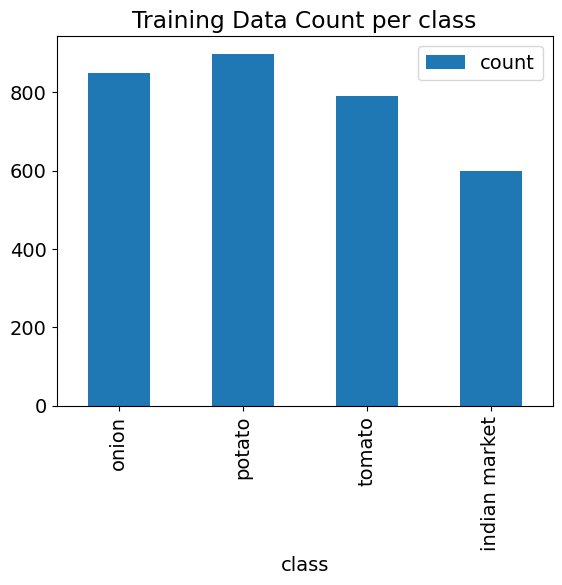

In [12]:
## Let's now Plot the Data Distribution of Training Data across Classes
df_count_train = pd.DataFrame({
    "class": count_dict_train.keys(),     # keys of count_dict are class labels
    "count": count_dict_train.values(),   # value of count_dict contain counts of each class
})
print("Count of training samples per class:\n", df_count_train)

# draw a bar plot using pandas in-built plotting function
df_count_train.plot.bar(x='class', y='count', title="Training Data Count per class")

**Splitting the Train data into train-validation for further Calculations**

In [13]:
import shutil
rootdir= 'ninjacart_data/train/' #path of the original folder
classes = list(count_dict_train.keys())
for i in classes:
  os.makedirs(rootdir +'train_split/' + i)
  os.makedirs(rootdir +'validation_split/' + i)
  source = rootdir + '/' + i
  allFileNames = os.listdir(source)
  np.random.shuffle(allFileNames)
  val_ratio = 0.20
  train_FileNames, val_FileNames = np.split(np.array(allFileNames),
                                                      [int(len(allFileNames)* (1 - val_ratio))])

  train_FileNames = [source+'/'+ name for name in train_FileNames.tolist()]
  val_FileNames = [source+'/' + name for name in val_FileNames.tolist()]
  for name in train_FileNames:
    shutil.copy(name, rootdir +'train_split/' + i)
  for name in val_FileNames:
    shutil.copy(name, rootdir +'validation_split/' + i)

**Finding the number of images per section in each train,validation and test data.**

In [14]:
class_dirs = os.listdir("ninjacart_data/train/train_split/") # list all directories inside "train" folder
image_dict_train_split = {} # dict to store image array(key) for every class(value)
count_dict_train_split = {} # dict to store count of files(key) for every class(value)
# iterate over all class_dirs
for cls in class_dirs:
    # get list of all paths inside the subdirectory
    file_paths = glob.glob(f'ninjacart_data/train/train_split/{cls}/*')
    # count number of files in each class and add it to count_dict
    count_dict_train_split[cls] = len(file_paths)
    # select random item from list of image paths
    image_path = random.choice(file_paths)
    # load image using keras utility function and save it in image_dict
    image_dict_train_split[cls] = tf.keras.utils.load_img(image_path)

In [15]:
count_dict_train_split

{'onion': 679, 'potato': 718, 'tomato': 631, 'indian market': 479}

In [16]:
class_dirs = os.listdir("ninjacart_data/train/validation_split/") # list all directories inside "train" folder
image_dict_validation_split = {} # dict to store image array(key) for every class(value)
count_dict_validation_split = {} # dict to store count of files(key) for every class(value)
# iterate over all class_dirs
for cls in class_dirs:
    # get list of all paths inside the subdirectory
    file_paths = glob.glob(f'ninjacart_data/train/validation_split/{cls}/*')
    # count number of files in each class and add it to count_dict
    count_dict_validation_split[cls] = len(file_paths)
    # select random item from list of image paths
    image_path = random.choice(file_paths)
    # load image using keras utility function and save it in image_dict
    image_dict_validation_split[cls] = tf.keras.utils.load_img(image_path)

In [17]:
count_dict_validation_split

{'onion': 170, 'potato': 180, 'tomato': 158, 'indian market': 120}

In [18]:
class_dirs = os.listdir("ninjacart_data/test/") # list all directories inside "train" folder
image_dict_test = {} # dict to store image array(key) for every class(value)
count_dict_test = {} # dict to store count of files(key) for every class(value)
# iterate over all class_dirs
for cls in class_dirs:
    # get list of all paths inside the subdirectory
    file_paths = glob.glob(f'ninjacart_data/test/{cls}/*')
    # count number of files in each class and add it to count_dict
    count_dict_test[cls] = len(file_paths)
    # select random item from list of image paths
    image_path = random.choice(file_paths)
    # load image using keras utility function and save it in image_dict
    image_dict_test[cls] = tf.keras.utils.load_img(image_path)

In [19]:
count_dict_test

{'onion': 83, 'potato': 81, 'tomato': 106, 'indian market': 81}

**Visulasing Some images from each section of train data**

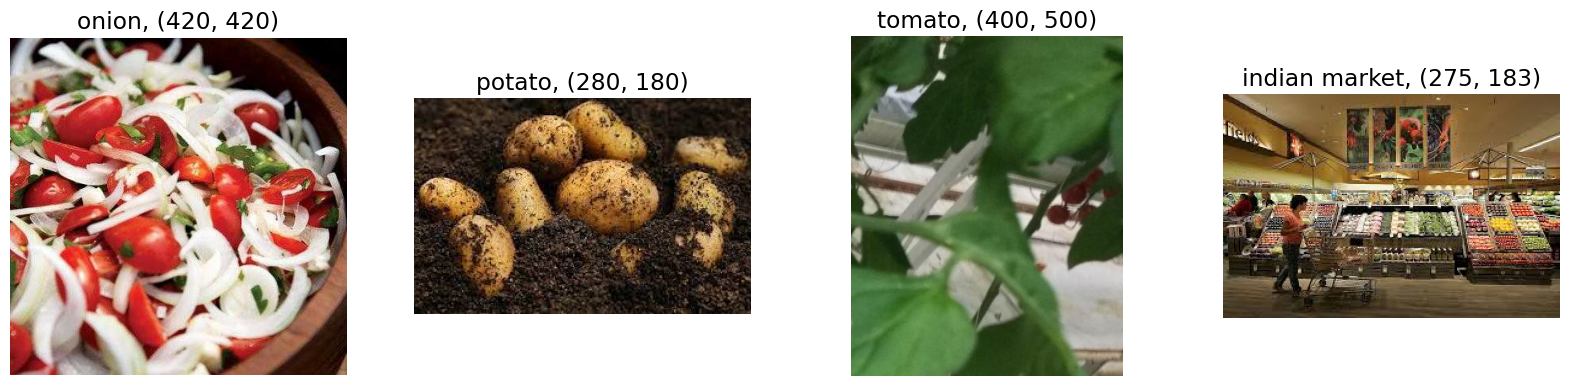

In [20]:
## Viz Random Sample from each class

plt.figure(figsize=(20, 15))
# iterate over dictionary items (class label, image array)
for i, (cls,img) in enumerate(image_dict_train_split.items()):
    # create a subplot axis
    ax = plt.subplot(3, 4, i + 1)
    # plot each image
    plt.imshow(img)
    # set "class name" along with "image size" as title
    plt.title(f'{cls}, {img.size}')
    plt.axis("off")

Count of training samples per class:
            class  count
0          onion    679
1         potato    718
2         tomato    631
3  indian market    479


<Axes: title={'center': 'Training Data Count per class'}, xlabel='class'>

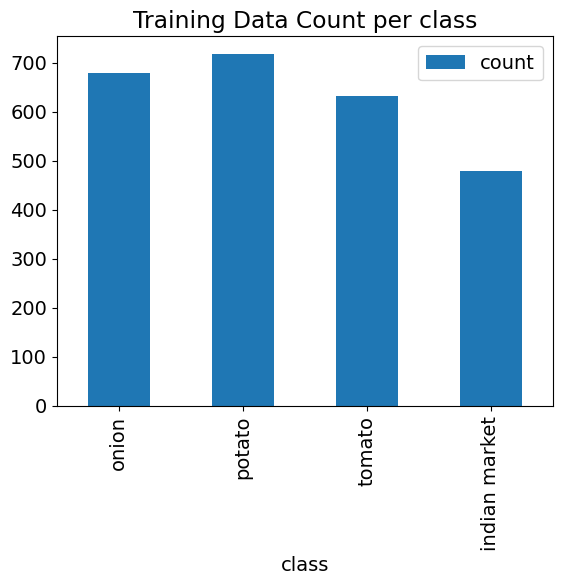

In [21]:
## Let's now Plot the Data Distribution of Training Data across Classes
df_count_train_split = pd.DataFrame({
    "class": count_dict_train_split.keys(),     # keys of count_dict are class labels
    "count": count_dict_train_split.values(),   # value of count_dict contain counts of each class
})
print("Count of training samples per class:\n", df_count_train_split)

# draw a bar plot using pandas in-built plotting function
df_count_train_split.plot.bar(x='class', y='count', title="Training Data Count per class")

# Baseline CNN Classifier model

In [22]:
train_data = tf.keras.utils.image_dataset_from_directory("ninjacart_data/train/train_split/",shuffle =True, seed=123,image_size=(224, 224))
validation_data = tf.keras.utils.image_dataset_from_directory("ninjacart_data/train/validation_split/",shuffle =True, seed=123,image_size=(224, 224))
test_data  = tf.keras.utils.image_dataset_from_directory("ninjacart_data/test/",shuffle =False, seed=123,image_size=(224, 224))

data_preprocess = tf.keras.Sequential(
    name="data_preprocess",
    layers=[ layers.Rescaling(1.0/255),]
)

# Perform Data Processing on the train, val, test dataset
train_ds = train_data.map(lambda x, y: (data_preprocess(x), y))
validation_ds = validation_data.map(lambda x, y: (data_preprocess(x), y))
test_ds = test_data.map(lambda x, y: (data_preprocess(x), y))

Found 2507 files belonging to 4 classes.
Found 628 files belonging to 4 classes.
Found 351 files belonging to 4 classes.


In [23]:
def baseline(height=224, width=224):
    num_classes = 4
    hidden_size1 = 256
    hidden_size2 = 128

    model = keras.Sequential(
        name="model_cnn",
        layers=[
            layers.Conv2D(filters=16, kernel_size=3, padding="same", activation='relu', input_shape=(height, width, 3)),
            layers.Conv2D(filters=16, kernel_size=3, padding="same", activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=16, kernel_size=3, padding="same", activation='relu'),
            layers.Conv2D(filters=16, kernel_size=3, padding="same", activation='relu'),
            layers.MaxPooling2D(),
            layers.Flatten(),
            layers.Dense(units=hidden_size1, activation='relu'),
            layers.Dense(units=hidden_size2, activation='relu'),
            layers.Dense(units=num_classes, activation='softmax')
        ]
    )
    return model

In [24]:
model = baseline()
model.summary()

Model: "model_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 16)      2320      
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 16)      2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 16)       0         
 2D)                                                     

In [25]:
train_data = tf.keras.utils.image_dataset_from_directory("ninjacart_data/train/train_split/",shuffle =True, seed=123,image_size=(224, 224))
validation_data = tf.keras.utils.image_dataset_from_directory("ninjacart_data/train/validation_split/",shuffle =True, seed=123,image_size=(224, 224))
test_data  = tf.keras.utils.image_dataset_from_directory("ninjacart_data/test/",shuffle =False, seed=123,image_size=(224, 224))

data_preprocess = tf.keras.Sequential(
    name="data_preprocess",
    layers=[ layers.Rescaling(1.0/255),]
)

# Perform Data Processing on the train, val, test dataset
train_ds = train_data.map(lambda x, y: (data_preprocess(x), y))
validation_ds = validation_data.map(lambda x, y: (data_preprocess(x), y))
test_ds = test_data.map(lambda x, y: (data_preprocess(x), y))

Found 2507 files belonging to 4 classes.
Found 628 files belonging to 4 classes.
Found 351 files belonging to 4 classes.


In [26]:
def compile_train_v1(model, train_ds, val_ds, ckpt_path="/tmp/checkpoint"):
    epochs = 8
    early_stopping = keras.callbacks.EarlyStopping(patience=2)
    model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

    model_fit = model.fit(train_ds, validation_data=validation_ds, epochs=epochs, callbacks=[
        keras.callbacks.ModelCheckpoint(ckpt_path, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True,callbacks=early_stopping),
    ])
    return model_fit

In [27]:
model_fit = compile_train_v1(model, train_ds, validation_ds)

Epoch 1/8
79/79 [==============================] - 325s 4s/step - loss: 1.0444 - accuracy: 0.5365 - val_loss: 0.6745 - val_accuracy: 0.7006
Epoch 2/8
79/79 [==============================] - 341s 4s/step - loss: 0.5766 - accuracy: 0.7575 - val_loss: 0.5829 - val_accuracy: 0.7452
Epoch 3/8
79/79 [==============================] - 345s 4s/step - loss: 0.4403 - accuracy: 0.8313 - val_loss: 0.4963 - val_accuracy: 0.7978
Epoch 4/8
79/79 [==============================] - 352s 4s/step - loss: 0.3308 - accuracy: 0.8664 - val_loss: 0.4597 - val_accuracy: 0.8248
Epoch 5/8
79/79 [==============================] - 342s 4s/step - loss: 0.2110 - accuracy: 0.9210 - val_loss: 0.6810 - val_accuracy: 0.7516
Epoch 6/8
79/79 [==============================] - 318s 4s/step - loss: 0.1233 - accuracy: 0.9533 - val_loss: 0.6498 - val_accuracy: 0.7978
Epoch 7/8
79/79 [==============================] - 336s 4s/step - loss: 0.0701 - accuracy: 0.9737 - val_loss: 1.3264 - val_accuracy: 0.7197
Epoch 8/8
79/79 [===

In [28]:
# helper function to annotate maximum values in the plots
def annot_max(x,y, xytext=(0.94,0.96), ax=None, only_y=True):
    xmax = x[np.argmax(y)]
    ymax = max(y)
    if only_y:
        text = "{:.2f}%".format(ymax)
    else:
        text= "x={:.2f}, y={:.2f}%".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=xytext, **kw)

def plot_accuracy(model_fit):
    #accuracy graph
    x = range(0,len(model_fit.history['accuracy']))
    y_train = [acc * 100 for acc in model_fit.history['accuracy']]
    y_val = [acc * 100 for acc in model_fit.history['val_accuracy']]

    plt.plot(x, y_train, label='Train', color='b')
    annot_max(x, y_train, xytext=(0.7,0.9))
    plt.plot(x, y_val, label='Val', color='r')
    annot_max(x, y_val, xytext=(0.8,0.7))
    plt.ylabel('Accuracy', fontsize=15)
    plt.xlabel('epoch', fontsize=15)
    plt.legend()
    plt.show()

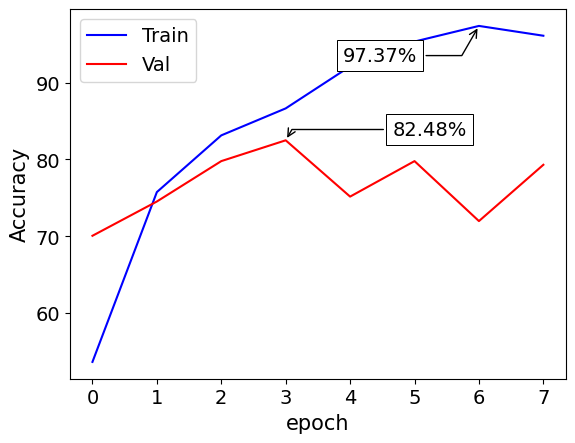

In [29]:
plot_accuracy(model_fit)

In [34]:
from sklearn.metrics import confusion_matrix
from PIL import Image
from tensorflow.keras.preprocessing import image
def labels_confusion_matrix(validation_folder):

    folder_path=validation_folder

    mapping={}
    for i,j in enumerate(sorted(os.listdir(folder_path))):
        mapping[j]=i

    files=[]
    real=[]
    predicted=[]

    for i in os.listdir(folder_path):

        true=os.path.join(folder_path,i)
        true=true.split('/')[-1]
        true=mapping[true]

        for j in os.listdir(os.path.join(folder_path,i)):

            img_ = image.load_img(os.path.join(folder_path,i,j), target_size=(224,224))
            img_array = image.img_to_array(img_)
            img_processed = np.expand_dims(img_array, axis=0)
            img_processed /= 255.
            prediction = model.predict(img_processed)
            index = np.argmax(prediction)

            predicted.append(index)
            real.append(true)

    return (real,predicted)

def print_confusion_matrix(real,predicted):
    total_output_labels = 4
    cmap="turbo"
    cm_plot_labels = [i for i in range(4)]

    cm = confusion_matrix(y_true=real, y_pred=predicted)
    df_cm = pd.DataFrame(cm,cm_plot_labels,cm_plot_labels)
    sns.set(font_scale=1.2) # for label size
    plt.figure(figsize = (15,10))
    s=sns.heatmap(df_cm,fmt="d", annot=True,cmap=cmap) # font size

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png')
    plt.show()

In [35]:
y_true,y_pred=labels_confusion_matrix('ninjacart_data/test/')

1/1 [==============================] - 0s 49ms/step



Test Accuracy: 76.92%



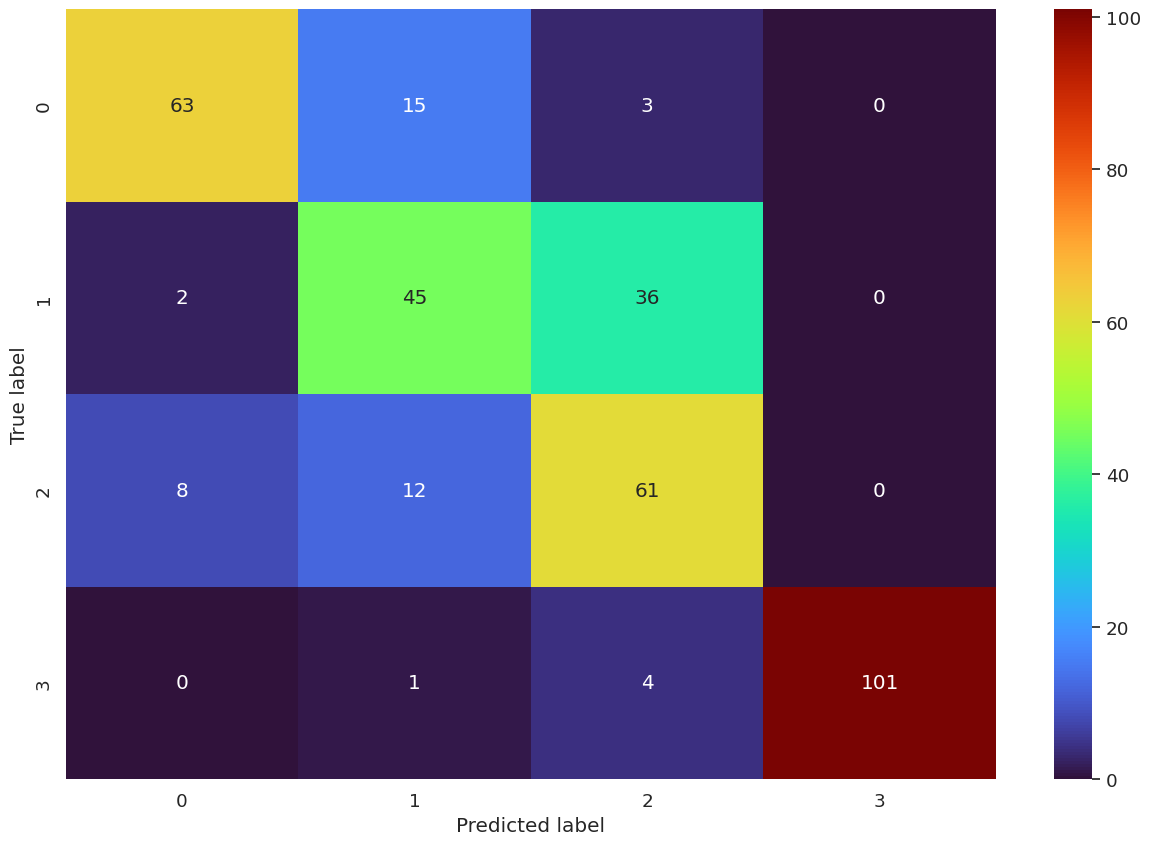

In [36]:
test_acc = metrics.accuracy_score(y_true, y_pred) * 100
print(f'\nTest Accuracy: {test_acc:.2f}%\n')
print_confusion_matrix(y_true,y_pred)

**Data Augmentation**

In [45]:
def preprocess_v2(train_data, val_data, test_data, target_height=224, target_width=224):

    # Data Processing Stage with resizing and rescaling operations #same as before for test,val
    data_preprocess = keras.Sequential(
        name="data_preprocess",
        layers=[
            layers.Resizing(target_height, target_width),
            layers.Rescaling(1.0/255),
        ]
    )

    # Data Processing Stage with resizing and rescaling operations
    data_augmentation = keras.Sequential(
        name="data_augmentation",
        layers=[
            layers.Resizing(156, 156), # First resize to 156,156
            layers.RandomCrop(target_height, target_width), # Then randomly crop 128,128 region
            # layers.RandomBrightness(0.2), # Modify brightness by 0.2 factor
            layers.Rescaling(1.0/255), # Finally rescale
        ]
    )

    # Perform Data Processing on the train, val, test dataset
    train_ds = train_data.map(
        lambda x, y: (data_augmentation(x), y), num_parallel_calls=tf.data.AUTOTUNE
    ).prefetch(tf.data.AUTOTUNE)
    val_ds = val_data.map(
        lambda x, y: (data_preprocess(x), y), num_parallel_calls=tf.data.AUTOTUNE
    ).prefetch(tf.data.AUTOTUNE)
    test_ds = test_data.map(
        lambda x, y: (data_preprocess(x), y), num_parallel_calls=tf.data.AUTOTUNE
    ).prefetch(tf.data.AUTOTUNE)

    return train_ds, val_ds, test_ds

In [46]:
train_ds, val_ds, test_ds = preprocess_v2(train_data, validation_data, test_data)

In [47]:
model3 = baseline2()
model_fit = compile_train_v2(model3, train_ds, validation_ds, epochs=5)

Epoch 1/5
79/79 [==============================] - 330s 4s/step - loss: 0.8039 - accuracy: 0.6693 - val_loss: 1.2936 - val_accuracy: 0.4490 - lr: 0.0010
Epoch 2/5
79/79 [==============================] - 316s 4s/step - loss: 0.5457 - accuracy: 0.7850 - val_loss: 2.0782 - val_accuracy: 0.2516 - lr: 0.0010
Epoch 3/5
79/79 [==============================] - 332s 4s/step - loss: 0.4771 - accuracy: 0.8209 - val_loss: 2.4282 - val_accuracy: 0.2707 - lr: 0.0010
Epoch 4/5
79/79 [==============================] - 341s 4s/step - loss: 0.4375 - accuracy: 0.8325 - val_loss: 1.7877 - val_accuracy: 0.4140 - lr: 0.0010
Epoch 5/5
79/79 [==============================] - 322s 4s/step - loss: 0.4191 - accuracy: 0.8436 - val_loss: 1.0638 - val_accuracy: 0.5223 - lr: 0.0010


In [48]:
# helper function to annotate maximum values in the plots
def annot_max(x,y, xytext=(0.94,0.96), ax=None, only_y=True):
    xmax = x[np.argmax(y)]
    ymax = max(y)
    if only_y:
        text = "{:.2f}%".format(ymax)
    else:
        text= "x={:.2f}, y={:.2f}%".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=xytext, **kw)

def plot_accuracy(model_fit):
    #accuracy graph
    x = range(0,len(model_fit.history['accuracy']))
    y_train = [acc * 100 for acc in model_fit.history['accuracy']]
    y_val = [acc * 100 for acc in model_fit.history['val_accuracy']]

    plt.plot(x, y_train, label='Train', color='b')
    annot_max(x, y_train, xytext=(0.7,0.9))
    plt.plot(x, y_val, label='Val', color='r')
    annot_max(x, y_val, xytext=(0.8,0.7))
    plt.ylabel('Accuracy', fontsize=15)
    plt.xlabel('epoch', fontsize=15)
    plt.legend()
    plt.show()

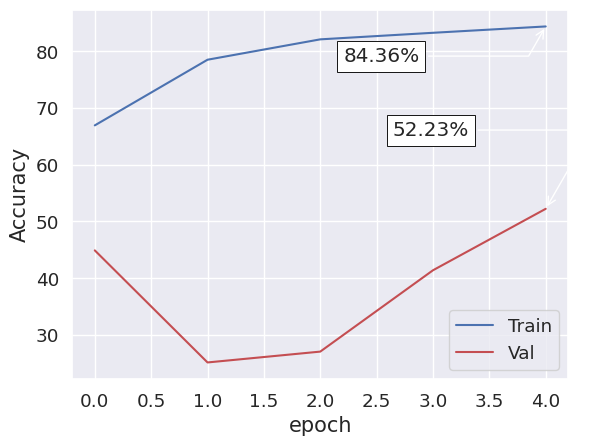

In [49]:
plot_accuracy(model_fit)

In [50]:
from sklearn.metrics import confusion_matrix
from PIL import Image
from tensorflow.keras.preprocessing import image
def labels_confusion_matrix(validation_folder):

    folder_path=validation_folder

    mapping={}
    for i,j in enumerate(sorted(os.listdir(folder_path))):
        mapping[j]=i

    files=[]
    real=[]
    predicted=[]

    for i in os.listdir(folder_path):

        true=os.path.join(folder_path,i)
        true=true.split('/')[-1]
        true=mapping[true]

        for j in os.listdir(os.path.join(folder_path,i)):

            img_ = image.load_img(os.path.join(folder_path,i,j), target_size=(224,224))
            img_array = image.img_to_array(img_)
            img_processed = np.expand_dims(img_array, axis=0)
            img_processed /= 255.
            prediction = model3.predict(img_processed)
            index = np.argmax(prediction)

            predicted.append(index)
            real.append(true)

    return (real,predicted)

def print_confusion_matrix(real,predicted):
    total_output_labels = 4
    cmap="turbo"
    cm_plot_labels = [i for i in range(4)]

    cm = confusion_matrix(y_true=real, y_pred=predicted)
    df_cm = pd.DataFrame(cm,cm_plot_labels,cm_plot_labels)
    sns.set(font_scale=1.2) # for label size
    plt.figure(figsize = (15,10))
    s=sns.heatmap(df_cm,fmt="d", annot=True,cmap=cmap) # font size

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png')
    plt.show()

In [52]:
y_true,y_pred=labels_confusion_matrix('ninjacart_data/test/')

1/1 [==============================] - 0s 56ms/step



Test Accuracy: 55.84%



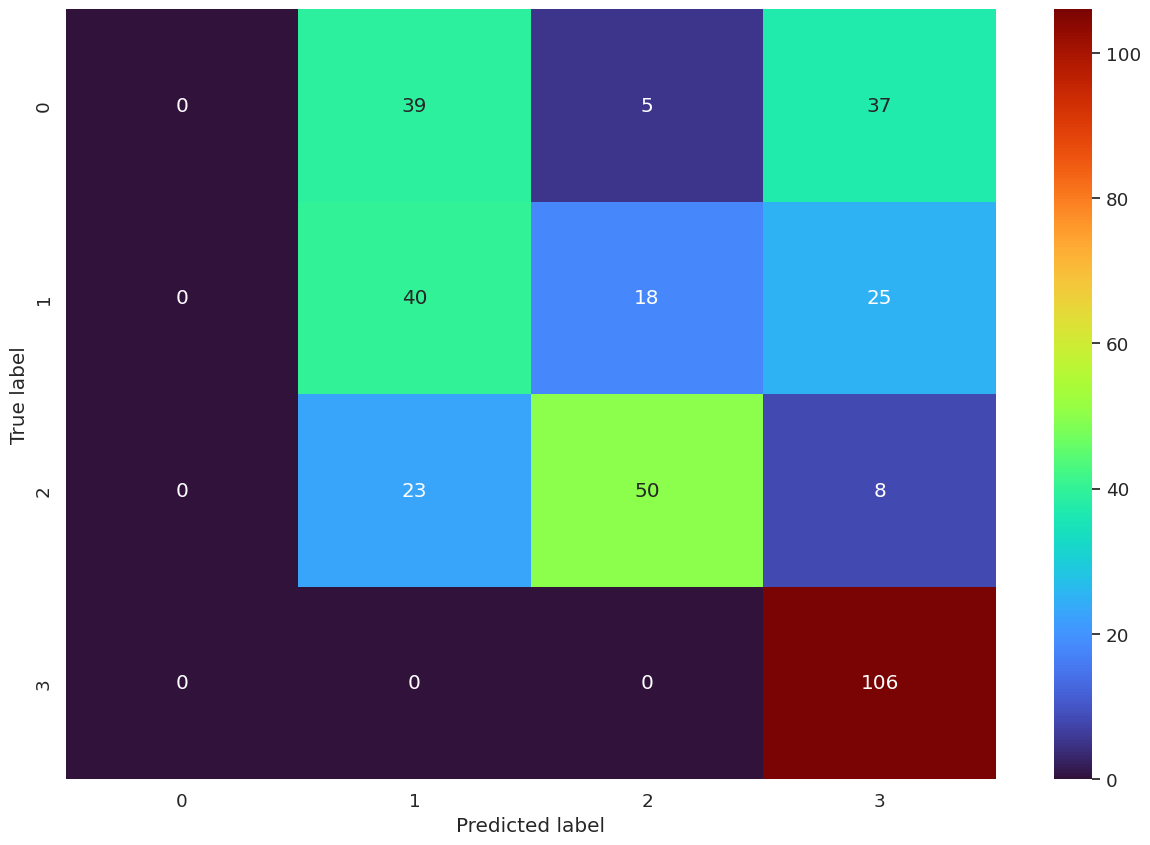

In [53]:
test_acc = metrics.accuracy_score(y_true, y_pred) * 100
print(f'\nTest Accuracy: {test_acc:.2f}%\n')
print_confusion_matrix(y_true,y_pred)

**Introducing BarchNormalization and dropout**

In [37]:
def baseline2(height=224, width=224):
    num_classes = 4
    hidden_size1 = 256
    hidden_size2 = 128

    model = keras.Sequential(
        name="model_cnn",
        layers=[
            layers.Conv2D(filters=16, kernel_size=3, padding="same", activation='relu', input_shape=(height, width, 3)),
            layers.Conv2D(filters=16, kernel_size=3, padding="same", activation='relu'),
            layers.MaxPooling2D(),
            layers.BatchNormalization(),
            layers.Conv2D(filters=16, kernel_size=3, padding="same", activation='relu'),
            layers.Conv2D(filters=16, kernel_size=3, padding="same", activation='relu'),
            layers.MaxPooling2D(),
            layers.BatchNormalization(),
            layers.GlobalAveragePooling2D(),
            layers.Dense(units=hidden_size1, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(units=hidden_size2, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(units=num_classes, activation='softmax')
        ]
    )
    return model

In [38]:
model2 = baseline2()
model2.summary()

Model: "model_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 conv2d_5 (Conv2D)           (None, 224, 224, 16)      2320      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 16)     64        
 ormalization)                                                   
                                                                 
 conv2d_6 (Conv2D)           (None, 112, 112, 16)      2320      
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 16)      23

In [39]:
def compile_train_v2(model, train_ds, val_ds, epochs=10, ckpt_path="/tmp/checkpoint"):
    callbacks = [
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.3, patience=5, min_lr=0.00001
        ),
        keras.callbacks.ModelCheckpoint(ckpt_path, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True),
        keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=10, min_delta=0.001, mode='min'
        )
    ]
    model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    model_fit = model.fit(train_ds, validation_data=validation_ds, epochs=epochs, callbacks=callbacks)
    return model_fit

In [40]:
model2 = baseline2()
model_fit2 = compile_train_v2(model2, train_ds, validation_ds, epochs=10)

Epoch 1/10
79/79 [==============================] - 341s 4s/step - loss: 0.8091 - accuracy: 0.6805 - val_loss: 1.6220 - val_accuracy: 0.2866 - lr: 0.0010
Epoch 2/10
79/79 [==============================] - 308s 4s/step - loss: 0.5436 - accuracy: 0.7946 - val_loss: 2.2250 - val_accuracy: 0.3328 - lr: 0.0010
Epoch 3/10
79/79 [==============================] - 308s 4s/step - loss: 0.4939 - accuracy: 0.8241 - val_loss: 2.3907 - val_accuracy: 0.3169 - lr: 0.0010
Epoch 4/10
79/79 [==============================] - 331s 4s/step - loss: 0.4530 - accuracy: 0.8237 - val_loss: 2.5839 - val_accuracy: 0.4045 - lr: 0.0010
Epoch 5/10
79/79 [==============================] - 311s 4s/step - loss: 0.4264 - accuracy: 0.8377 - val_loss: 1.6950 - val_accuracy: 0.4538 - lr: 0.0010
Epoch 6/10
79/79 [==============================] - 310s 4s/step - loss: 0.4026 - accuracy: 0.8552 - val_loss: 0.9546 - val_accuracy: 0.6449 - lr: 0.0010
Epoch 7/10
79/79 [==============================] - 310s 4s/step - loss: 0.3

In [41]:
# helper function to annotate maximum values in the plots
def annot_max(x,y, xytext=(0.94,0.96), ax=None, only_y=True):
    xmax = x[np.argmax(y)]
    ymax = max(y)
    if only_y:
        text = "{:.2f}%".format(ymax)
    else:
        text= "x={:.2f}, y={:.2f}%".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=xytext, **kw)

def plot_accuracy(model_fit):
    #accuracy graph
    x = range(0,len(model_fit.history['accuracy']))
    y_train = [acc * 100 for acc in model_fit.history['accuracy']]
    y_val = [acc * 100 for acc in model_fit.history['val_accuracy']]

    plt.plot(x, y_train, label='Train', color='b')
    annot_max(x, y_train, xytext=(0.7,0.9))
    plt.plot(x, y_val, label='Val', color='r')
    annot_max(x, y_val, xytext=(0.8,0.7))
    plt.ylabel('Accuracy', fontsize=15)
    plt.xlabel('epoch', fontsize=15)
    plt.legend()
    plt.show()

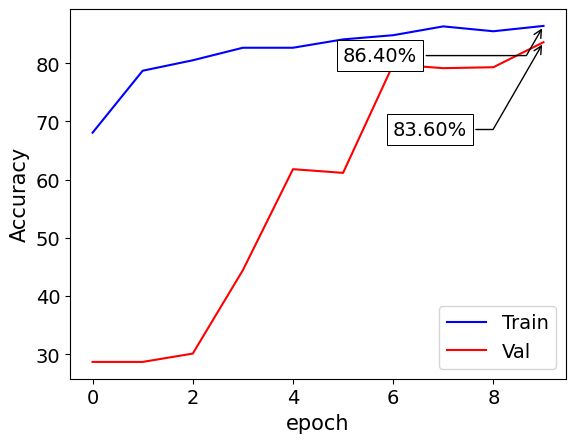

In [ ]:
plot_accuracy(model_fit)

In [42]:
from sklearn.metrics import confusion_matrix
from PIL import Image
from tensorflow.keras.preprocessing import image
def labels_confusion_matrix(validation_folder):

    folder_path=validation_folder

    mapping={}
    for i,j in enumerate(sorted(os.listdir(folder_path))):
        mapping[j]=i

    files=[]
    real=[]
    predicted=[]

    for i in os.listdir(folder_path):

        true=os.path.join(folder_path,i)
        true=true.split('/')[-1]
        true=mapping[true]

        for j in os.listdir(os.path.join(folder_path,i)):

            img_ = image.load_img(os.path.join(folder_path,i,j), target_size=(224,224))
            img_array = image.img_to_array(img_)
            img_processed = np.expand_dims(img_array, axis=0)
            img_processed /= 255.
            prediction = model2.predict(img_processed)
            index = np.argmax(prediction)

            predicted.append(index)
            real.append(true)

    return (real,predicted)

def print_confusion_matrix(real,predicted):
    total_output_labels = 4
    cmap="turbo"
    cm_plot_labels = [i for i in range(4)]

    cm = confusion_matrix(y_true=real, y_pred=predicted)
    df_cm = pd.DataFrame(cm,cm_plot_labels,cm_plot_labels)
    sns.set(font_scale=1.2) # for label size
    plt.figure(figsize = (15,10))
    s=sns.heatmap(df_cm,fmt="d", annot=True,cmap=cmap) # font size

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png')
    plt.show()

In [51]:
y_true,y_pred=labels_confusion_matrix('ninjacart_data/test/')

1/1 [==============================] - 0s 92ms/step



Test Accuracy: 86.61%



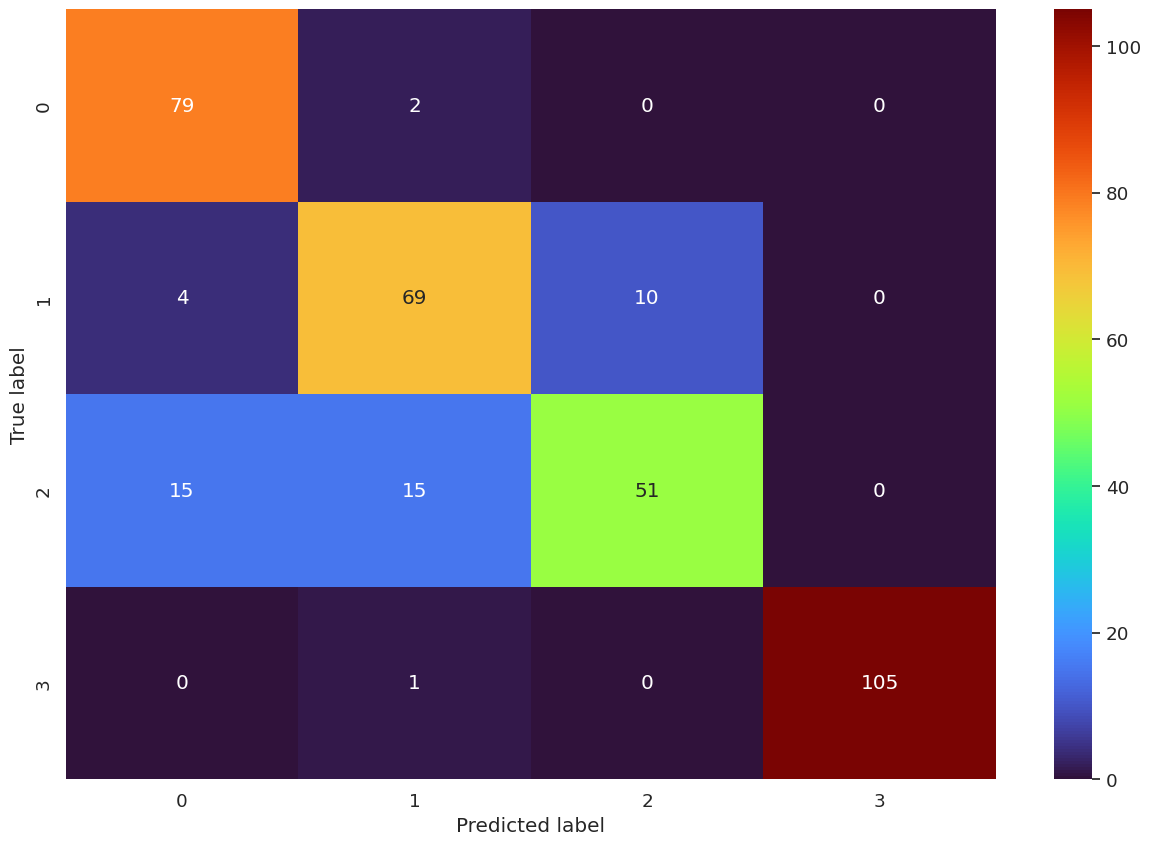

In [44]:
test_acc = metrics.accuracy_score(y_true, y_pred) * 100
print(f'\nTest Accuracy: {test_acc:.2f}%\n')
print_confusion_matrix(y_true,y_pred)

**Using VGG net Pre-Trained Model using Transfer Learning**

In [54]:
pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=[224,224, 3])
pretrained_model.trainable=False
vgg16_model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4, activation='softmax')
])

58889256/58889256 [==============================] - 0s 0us/step


In [55]:
vgg16_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_12 (Dense)            (None, 4)                 100356    
                                                                 
Total params: 14,815,044
Trainable params: 100,356
Non-trainable params: 14,714,688
_________________________________________________________________


In [56]:
import functools
top5_acc = functools.partial(tf.keras.metrics.SparseTopKCategoricalAccuracy(k=1))

vgg16_model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [57]:
history = vgg16_model.fit(train_ds, epochs=5,
                    validation_data=validation_ds)

Epoch 1/5
79/79 [==============================] - 2084s 26s/step - loss: 0.4732 - accuracy: 0.8045 - val_loss: 0.3350 - val_accuracy: 0.8678
Epoch 2/5
79/79 [==============================] - 2053s 26s/step - loss: 0.1149 - accuracy: 0.9625 - val_loss: 0.3302 - val_accuracy: 0.8710
Epoch 3/5
79/79 [==============================] - 1995s 25s/step - loss: 0.0514 - accuracy: 0.9920 - val_loss: 0.2950 - val_accuracy: 0.8885
Epoch 4/5
79/79 [==============================] - 1990s 25s/step - loss: 0.0295 - accuracy: 0.9984 - val_loss: 0.2693 - val_accuracy: 0.8965
Epoch 5/5
79/79 [==============================] - 2037s 26s/step - loss: 0.0188 - accuracy: 0.9996 - val_loss: 0.2665 - val_accuracy: 0.9029


In [58]:
def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])

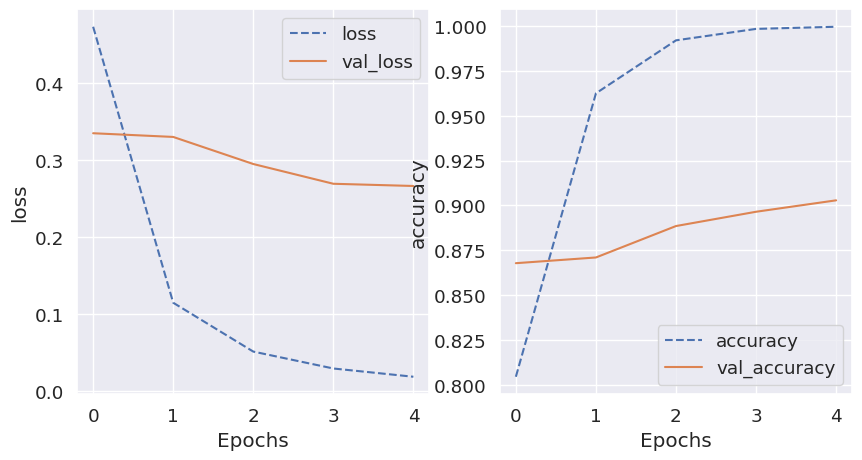

In [59]:
training_plot(['loss', 'accuracy'], history)

In [63]:
from sklearn.metrics import confusion_matrix
from PIL import Image
from tensorflow.keras.preprocessing import image
def labels_confusion_matrix(validation_folder):

    folder_path=validation_folder

    mapping={}
    for i,j in enumerate(sorted(os.listdir(folder_path))):
        mapping[j]=i

    files=[]
    real=[]
    predicted=[]

    for i in os.listdir(folder_path):

        true=os.path.join(folder_path,i)
        true=true.split('/')[-1]
        true=mapping[true]

        for j in os.listdir(os.path.join(folder_path,i)):

            img_ = image.load_img(os.path.join(folder_path,i,j), target_size=(224,224))
            img_array = image.img_to_array(img_)
            img_processed = np.expand_dims(img_array, axis=0)
            img_processed /= 255.
            prediction = vgg16_model.predict(img_processed)
            index = np.argmax(prediction)

            predicted.append(index)
            real.append(true)

    return (real,predicted)

def print_confusion_matrix(real,predicted):
    total_output_labels = 4
    cmap="turbo"
    cm_plot_labels = [i for i in range(4)]

    cm = confusion_matrix(y_true=real, y_pred=predicted)
    df_cm = pd.DataFrame(cm,cm_plot_labels,cm_plot_labels)
    sns.set(font_scale=1.2) # for label size
    plt.figure(figsize = (15,10))
    s=sns.heatmap(df_cm,fmt="d", annot=True,cmap=cmap) # font size

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png')
    plt.show()

In [64]:
y_true,y_pred=labels_confusion_matrix('ninjacart_data/test/')

1/1 [==============================] - 1s 566ms/step



Test Accuracy: 88.03%



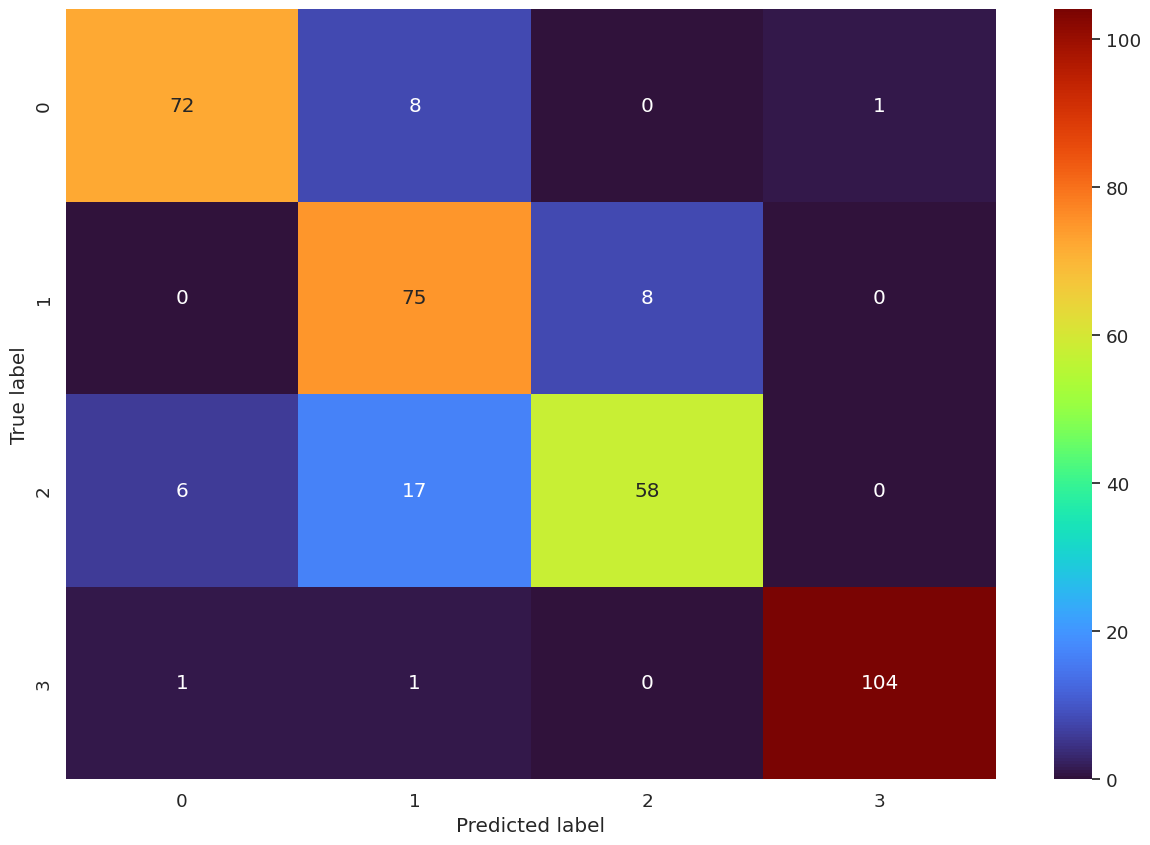

In [65]:
test_acc = metrics.accuracy_score(y_true, y_pred) * 100
print(f'\nTest Accuracy: {test_acc:.2f}%\n')
print_confusion_matrix(y_true,y_pred)

In [61]:
def plot_image(pred_array, true_label, img):
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(pred_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ".format(class_names[predicted_label],
                                100*np.max(pred_array),
                                ),
                                color=color)


11/11 [==============================] - 232s 21s/step


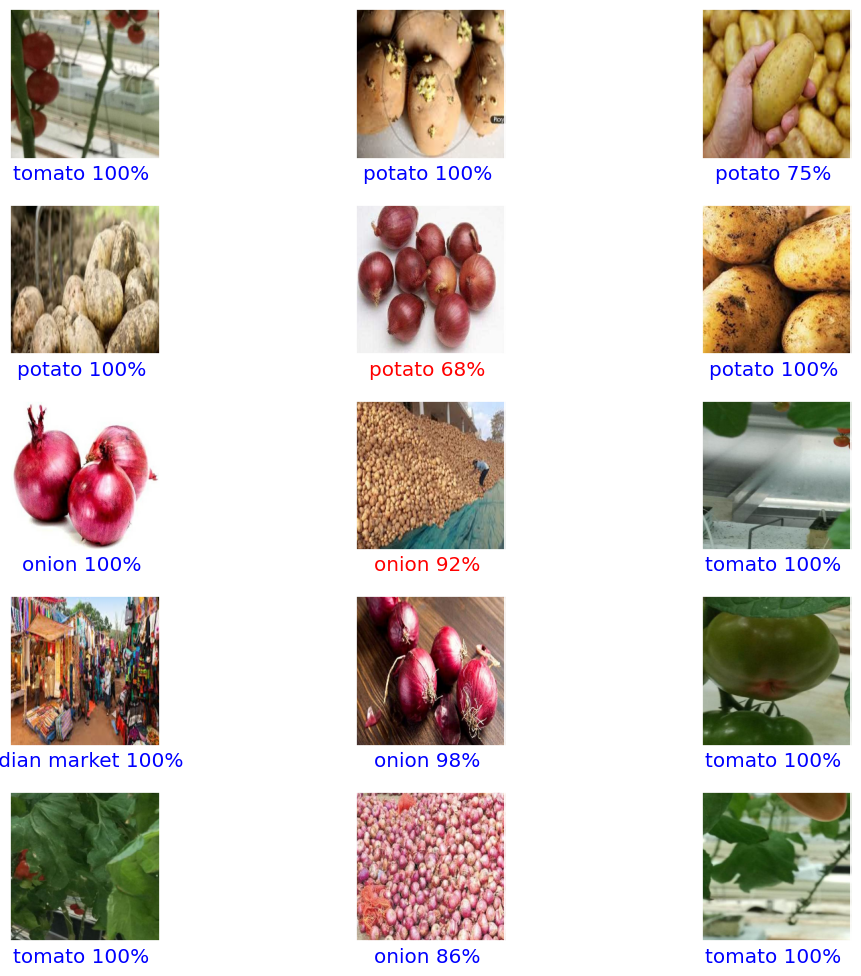

In [62]:
true_categories = tf.concat([y for x, y in test_ds], axis=0)
images = tf.concat([x for x, y in test_ds], axis=0)
y_pred = vgg16_model.predict(test_ds)
class_names = test_data.class_names

# Randomly sample 15 test images and plot it with their predicted labels, and the true labels.
indices = random.sample(range(len(images)), 15)
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(4*num_cols, 2*num_rows))
for i,index in enumerate(indices):
  plt.subplot(num_rows, num_cols, i+1)
  plot_image(y_pred[index], true_categories[index], images[index])

plt.tight_layout()
plt.show()

**Summary**

*  Total of 4 classes are present in Provided Dataset
*  Data is Balance as same number of images are present in Dataset
*  Accuracy of 76% is obtained for Baseline model but seems like Model is
   Overfitting by seeing comparision between Train and Validation Accuracy
*  Data Augmentation is not helpful in this case as Accuracy is dropped
*  After Introducing Batch Normalization and Dropout Accuracy is increased to 86.6%
*  To Increase Accuracy Further, Pretrained VGG-net is used and able to achieve around 88%